
Training FNN with validation...
Epoch 10/100, Train Loss: 0.0618, Test Loss: 0.0615
Epoch 20/100, Train Loss: 0.0512, Test Loss: 0.0493
Epoch 30/100, Train Loss: 0.0400, Test Loss: 0.0383
Epoch 40/100, Train Loss: 0.0286, Test Loss: 0.0273
Epoch 50/100, Train Loss: 0.0170, Test Loss: 0.0158
Epoch 60/100, Train Loss: 0.0086, Test Loss: 0.0077
Epoch 70/100, Train Loss: 0.0042, Test Loss: 0.0036
Epoch 80/100, Train Loss: 0.0029, Test Loss: 0.0024
Epoch 90/100, Train Loss: 0.0029, Test Loss: 0.0023
Epoch 100/100, Train Loss: 0.0029, Test Loss: 0.0023

Training RNN with validation...
Epoch 10/100, Train Loss: 0.0029, Test Loss: 0.0021
Epoch 20/100, Train Loss: 0.0028, Test Loss: 0.0021
Epoch 30/100, Train Loss: 0.0028, Test Loss: 0.0020
Epoch 40/100, Train Loss: 0.0027, Test Loss: 0.0020
Epoch 50/100, Train Loss: 0.0027, Test Loss: 0.0020
Epoch 60/100, Train Loss: 0.0027, Test Loss: 0.0020
Epoch 70/100, Train Loss: 0.0027, Test Loss: 0.0020
Epoch 80/100, Train Loss: 0.0027, Test Loss: 0.00

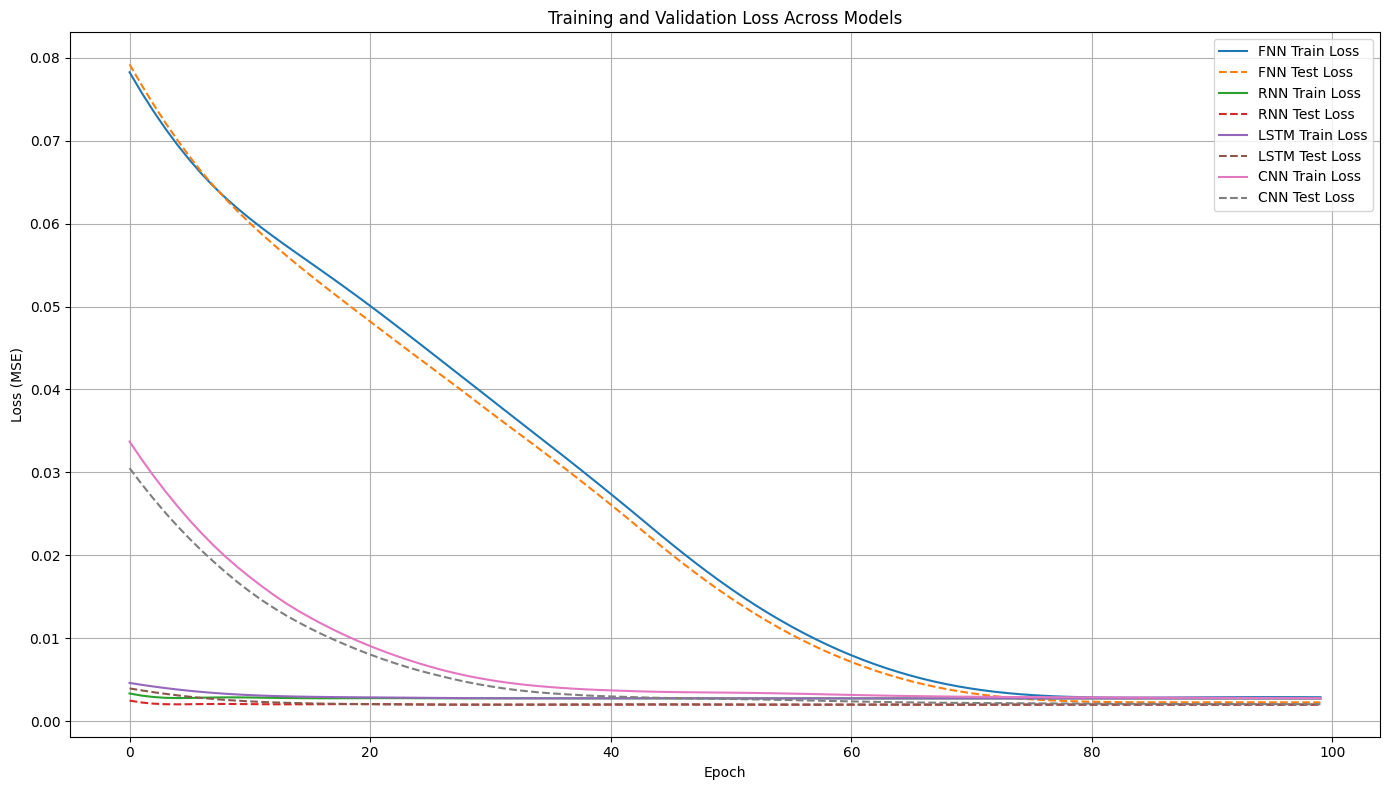

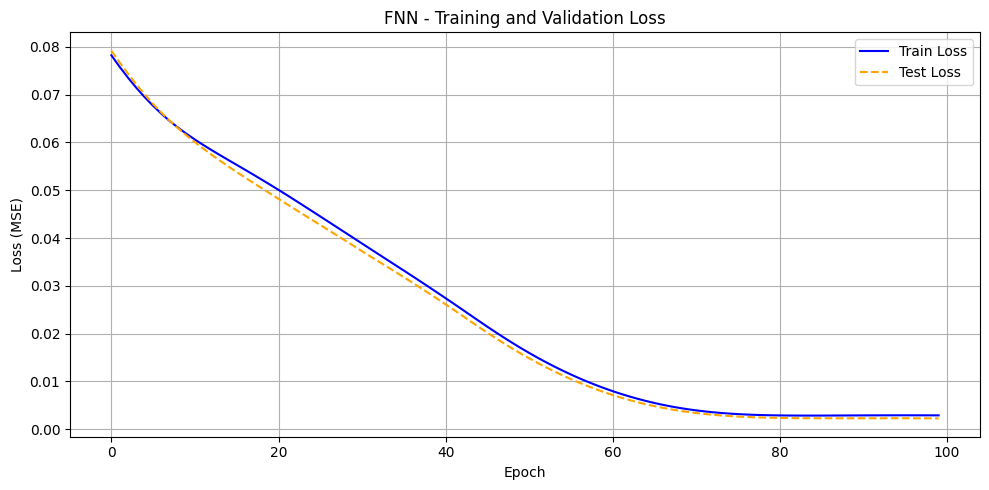

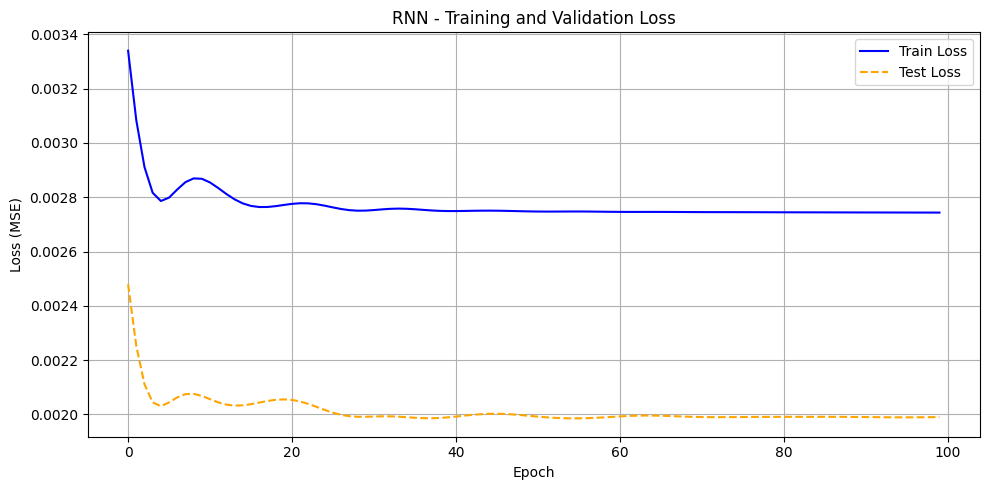

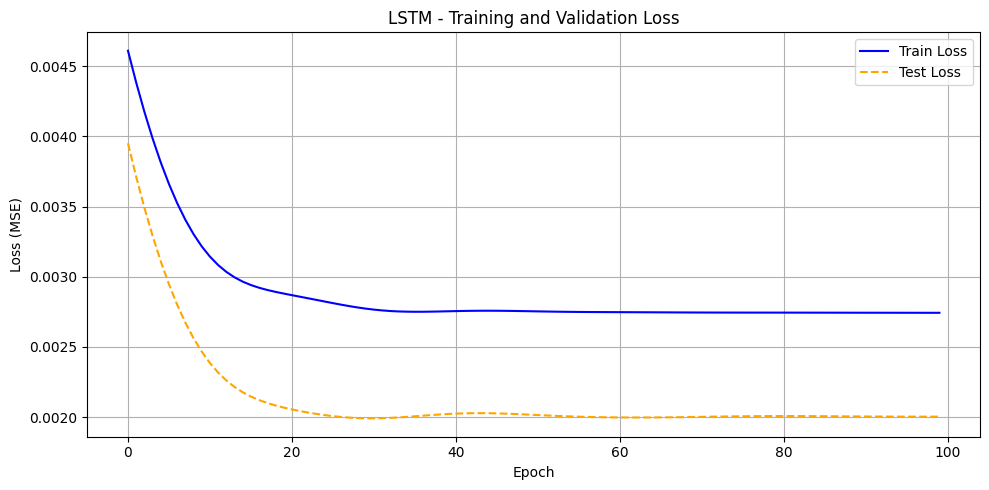

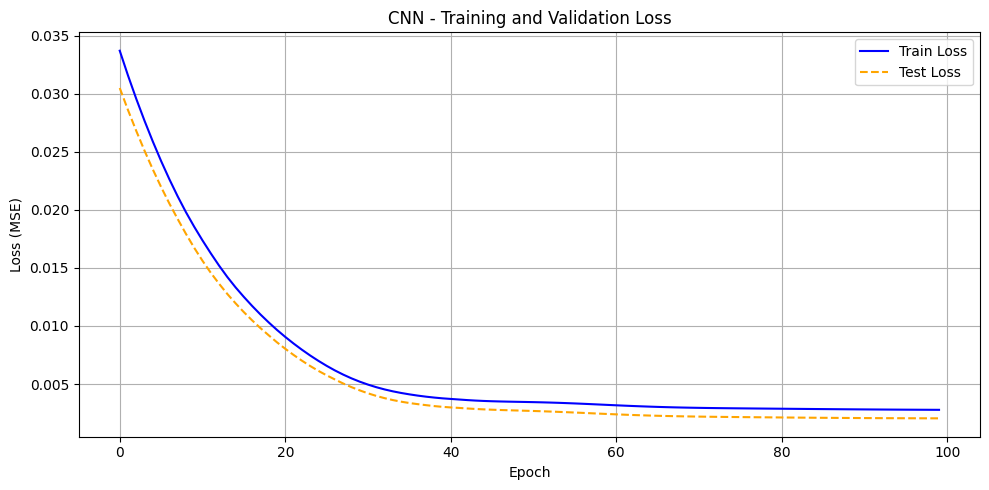


Performance by PID:
       PID  Data Points  FNN_RMSE     FNN_R2  RNN_RMSE     RNN_R2  LSTM_RMSE  \
0   JR8022            9  0.122648  -4.917215  0.109382  -3.706336   0.110651   
1   DK3500           48  0.036362  -3.868673  0.041295  -5.279521   0.041530   
2   SA0297           54  0.052009  -0.057193  0.053239  -0.107798   0.052836   
3   HV0618           45  0.045978  -1.157384  0.051912  -1.750139   0.052159   
4   BU4707           18  0.027267  -1.371943  0.017941  -0.026859   0.018354   
5   SF3079           27  0.079173  -6.872272  0.067875  -4.785762   0.068362   
6   MJ8002           24  0.069498  -0.721746  0.062764  -0.404231   0.063393   
7   MC7070           15  0.088539 -13.650336  0.082706 -11.783736   0.082502   
8   CC6740           66  0.044895   0.029776  0.046176  -0.026370   0.045971   
9   PC6771           57  0.040964  -0.895555  0.046045  -1.395018   0.045767   
10  JB3156           43  0.021001  -0.519357  0.019682  -0.334503   0.018038   
11  DC6359         

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("learning_curves", exist_ok=True)

# Load and prepare data
data = pd.read_csv("merged_data.csv")
data = data.dropna()

# Rename columns to handle case sensitivity
data = data.rename(columns={'pid': 'PID', 'Time': 'time'})

# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Verify PID column exists
if 'PID' not in data.columns:
    raise ValueError("PID column not found in data. Available columns: " + ", ".join(data.columns))

# Create time index for each PID group
data['time_index'] = data.groupby('PID').cumcount()

# Select features and target (we'll predict TAC_Reading)
X = data[['Pe_results', 'Comp_results']].values  # Features
y = data['TAC_Reading'].values  # Target (TAC_Reading)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape for regression

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

# ===================== Model Definitions (Same as Before) ===================== #
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(16 * input_size, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
input_size = X.shape[1]
models = {
    'FNN': FNN().to(device),
    'RNN': RNN().to(device),
    'LSTM': LSTM().to(device),
    'CNN': CNN(input_size).to(device)
}

# ===================== Enhanced Training Function ===================== #
def train_model(model, X_train, y_train, model_name, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Store losses
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    
    # Save learning curves
    learning_curve_df = pd.DataFrame({
        'epoch': range(epochs),
        'train_loss': train_losses
    })
    learning_curve_df.to_csv(f'learning_curves/{model_name}_learning_curve.csv', index=False)
    
    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'learning_curves/{model_name}_learning_curve.png')
    plt.close()
    
    # Save model
    torch.save(model.state_dict(), f'models/{model_name}.pth')

def train_model_with_validation(model, X_train, y_train, X_test, y_test, model_name, epochs=100, lr=0.001):
    """Enhanced training function that tracks both training and validation loss"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Store losses
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    
    # Save learning curves
    learning_curve_df = pd.DataFrame({
        'epoch': range(epochs),
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    learning_curve_df.to_csv(f'learning_curves/{model_name}_learning_curve.csv', index=False)
    
    return train_losses, test_losses

def plot_loss_curves(model_names):
    """Plot training and test loss curves for all models"""
    plt.figure(figsize=(14, 8))
    
    for model_name in model_names:
        try:
            # Load the saved learning curves
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            
            # Plot train and test losses
            plt.plot(curve_data['epoch'], curve_data['train_loss'], 
                    label=f'{model_name} Train Loss', linestyle='-')
            plt.plot(curve_data['epoch'], curve_data['test_loss'], 
                    label=f'{model_name} Test Loss', linestyle='--')
        except FileNotFoundError:
            print(f"Warning: Learning curve data not found for {model_name}")
    
    plt.title('Training and Validation Loss Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves/all_models_loss_curves.png')
    plt.show()

def plot_individual_loss_curves(model_names):
    """Plot separate loss curves for each model"""
    for model_name in model_names:
        try:
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            
            plt.figure(figsize=(10, 5))
            plt.plot(curve_data['epoch'], curve_data['train_loss'], 
                    label='Train Loss', linestyle='-', color='blue')
            plt.plot(curve_data['epoch'], curve_data['test_loss'], 
                    label='Test Loss', linestyle='--', color='orange')
            
            plt.title(f'{model_name} - Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (MSE)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'learning_curves/{model_name}_loss_curves.png')
            plt.show()
            
        except FileNotFoundError:
            print(f"Warning: Learning curve data not found for {model_name}")

# Modified main execution
if __name__ == "__main__":
    # Split data into train and test sets for validation during training
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
    
    # Train all models with validation tracking
    for model_name, model in models.items():
        print(f"\nTraining {model_name} with validation...")
        train_model_with_validation(model, X_train, y_train, X_test, y_test, model_name)
    
    # Plot all loss curves
    plot_loss_curves(models.keys())
    plot_individual_loss_curves(models.keys())
    
    # Continue with PID evaluation as before
    pid_results = evaluate_by_pid(models, data, scaler)


=== Training FNN model ===
Epoch [10/100], FNN - Train: 0.5512, Test: 0.3425, Total: 0.4468
Epoch [20/100], FNN - Train: 0.5083, Test: 0.1974, Total: 0.3529
Epoch [30/100], FNN - Train: 0.4481, Test: 0.0671, Total: 0.2576
Epoch [40/100], FNN - Train: 0.3927, Test: 0.0787, Total: 0.2357
Epoch [50/100], FNN - Train: 0.3770, Test: 0.0622, Total: 0.2196
Epoch [60/100], FNN - Train: 0.3380, Test: 0.0672, Total: 0.2026
Epoch [70/100], FNN - Train: 0.3241, Test: 0.0569, Total: 0.1905
Epoch [80/100], FNN - Train: 0.2876, Test: 0.0824, Total: 0.1850
Epoch [90/100], FNN - Train: 0.2367, Test: 0.0631, Total: 0.1499
Epoch [100/100], FNN - Train: 0.1917, Test: 0.0584, Total: 0.1251


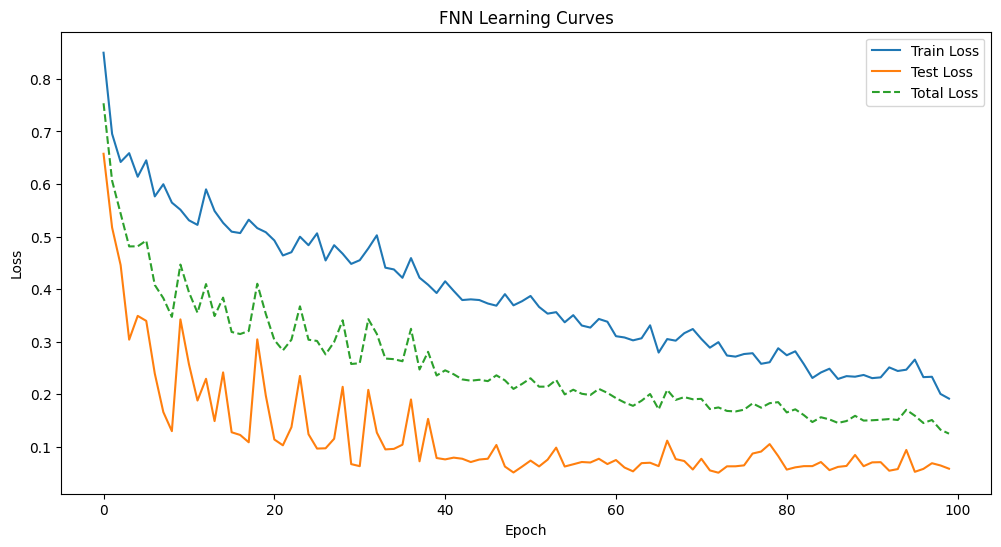

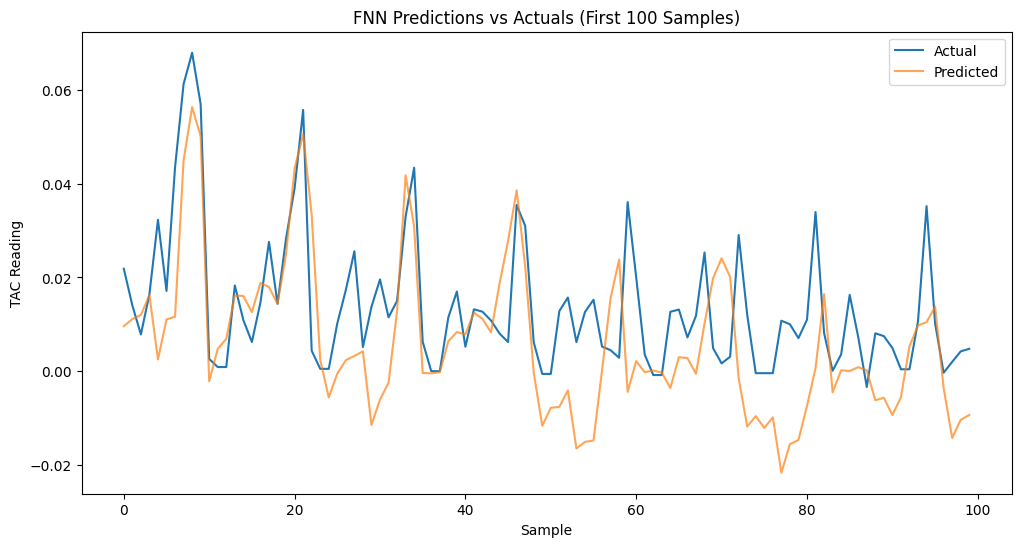


=== Training RNN model ===
Epoch [10/100], RNN - Train: 0.6659, Test: 0.0769, Total: 0.3714
Epoch [20/100], RNN - Train: 0.6275, Test: 0.2383, Total: 0.4329
Epoch [30/100], RNN - Train: 0.5588, Test: 0.1378, Total: 0.3483
Epoch [40/100], RNN - Train: 0.4882, Test: 0.1189, Total: 0.3035
Epoch [50/100], RNN - Train: 0.4659, Test: 0.1803, Total: 0.3231
Epoch [60/100], RNN - Train: 0.3823, Test: 0.1853, Total: 0.2838
Epoch [70/100], RNN - Train: 0.3109, Test: 0.1146, Total: 0.2127
Epoch [80/100], RNN - Train: 0.2956, Test: 0.0837, Total: 0.1897
Epoch [90/100], RNN - Train: 0.2211, Test: 0.1439, Total: 0.1825
Epoch [100/100], RNN - Train: 0.2054, Test: 0.0840, Total: 0.1447


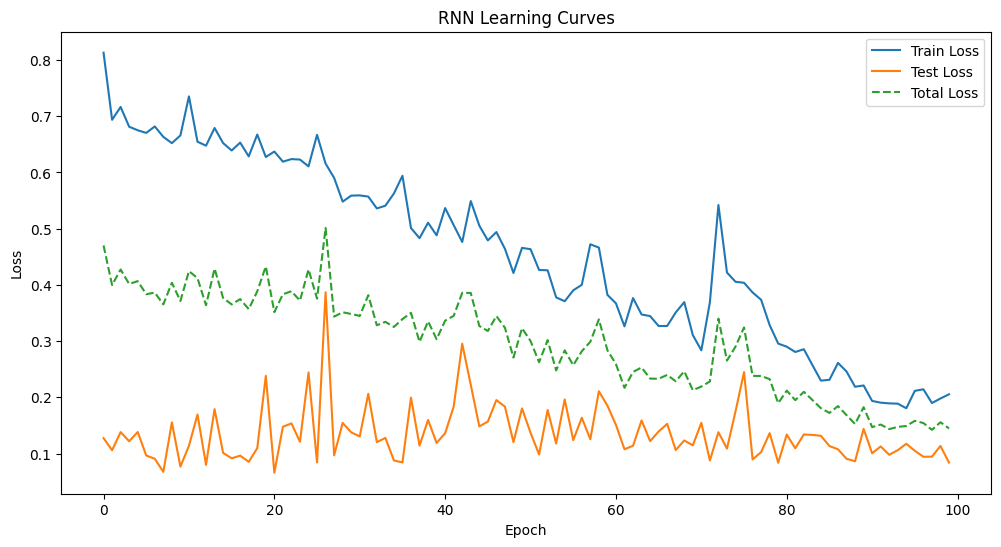

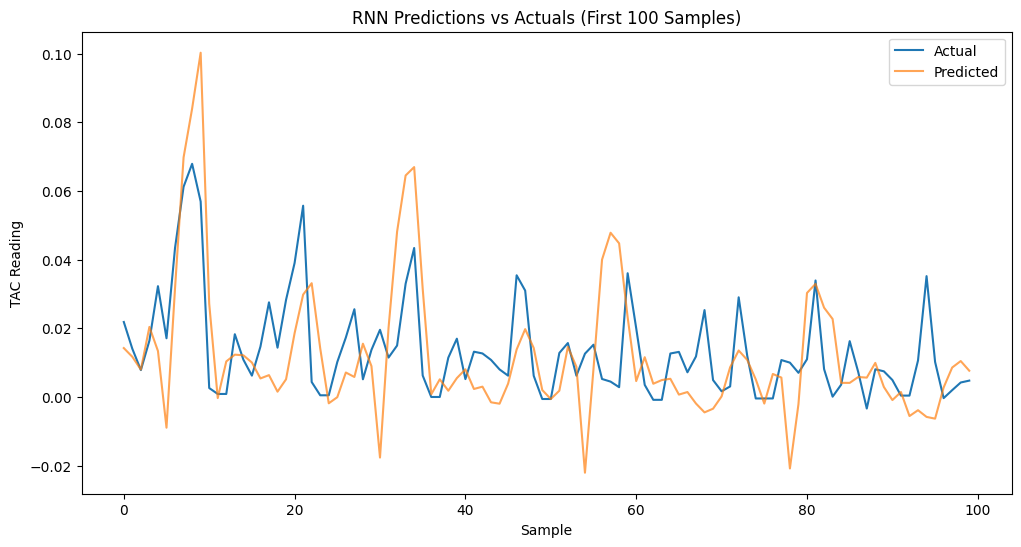


=== Training LSTM model ===
Epoch [10/100], LSTM - Train: 0.7145, Test: 0.0921, Total: 0.4033
Epoch [20/100], LSTM - Train: 0.5873, Test: 0.1186, Total: 0.3529
Epoch [30/100], LSTM - Train: 0.5520, Test: 0.1459, Total: 0.3490
Epoch [40/100], LSTM - Train: 0.5120, Test: 0.0847, Total: 0.2984
Epoch [50/100], LSTM - Train: 0.5035, Test: 0.2168, Total: 0.3602
Epoch [60/100], LSTM - Train: 0.4676, Test: 0.0936, Total: 0.2806
Epoch [70/100], LSTM - Train: 0.4147, Test: 0.1132, Total: 0.2640
Epoch [80/100], LSTM - Train: 0.4189, Test: 0.0930, Total: 0.2559
Epoch [90/100], LSTM - Train: 0.4249, Test: 0.0483, Total: 0.2366
Epoch [100/100], LSTM - Train: 0.4006, Test: 0.0811, Total: 0.2409


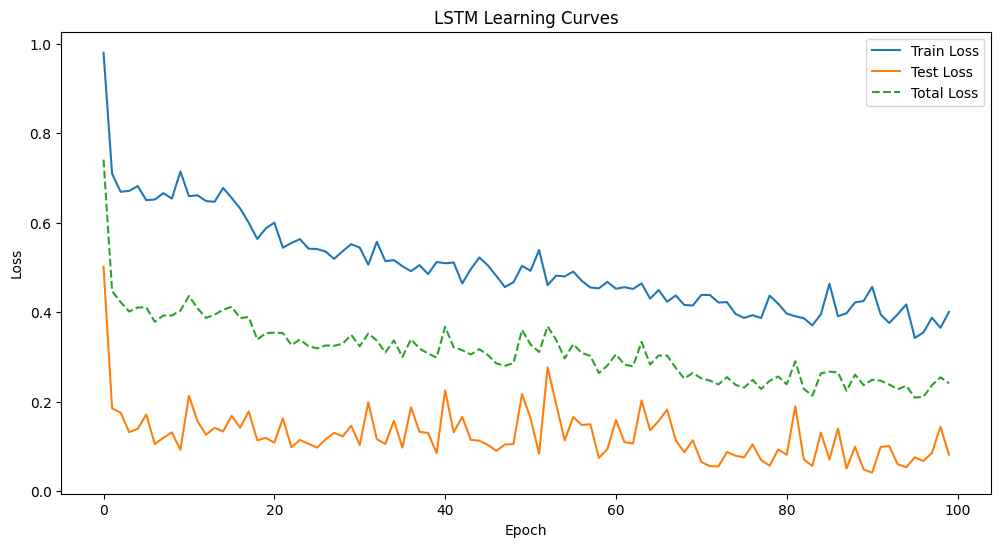

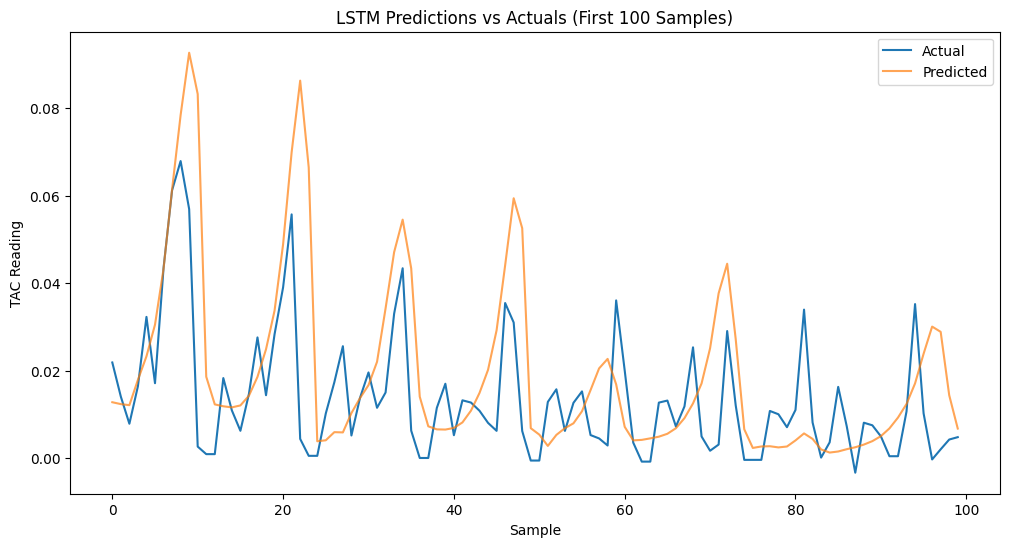


=== Training CNN model ===
Epoch [10/100], CNN - Train: 0.5651, Test: 0.3208, Total: 0.4429
Epoch [20/100], CNN - Train: 0.4604, Test: 0.3755, Total: 0.4179
Epoch [30/100], CNN - Train: 0.4003, Test: 0.2502, Total: 0.3252
Epoch [40/100], CNN - Train: 0.3459, Test: 0.1588, Total: 0.2524
Epoch [50/100], CNN - Train: 0.3038, Test: 0.0764, Total: 0.1901
Epoch [60/100], CNN - Train: 0.2716, Test: 0.1386, Total: 0.2051
Epoch [70/100], CNN - Train: 0.2468, Test: 0.0456, Total: 0.1462
Epoch [80/100], CNN - Train: 0.2266, Test: 0.0618, Total: 0.1442
Epoch [90/100], CNN - Train: 0.2014, Test: 0.0926, Total: 0.1470
Epoch [100/100], CNN - Train: 0.2069, Test: 0.0692, Total: 0.1380


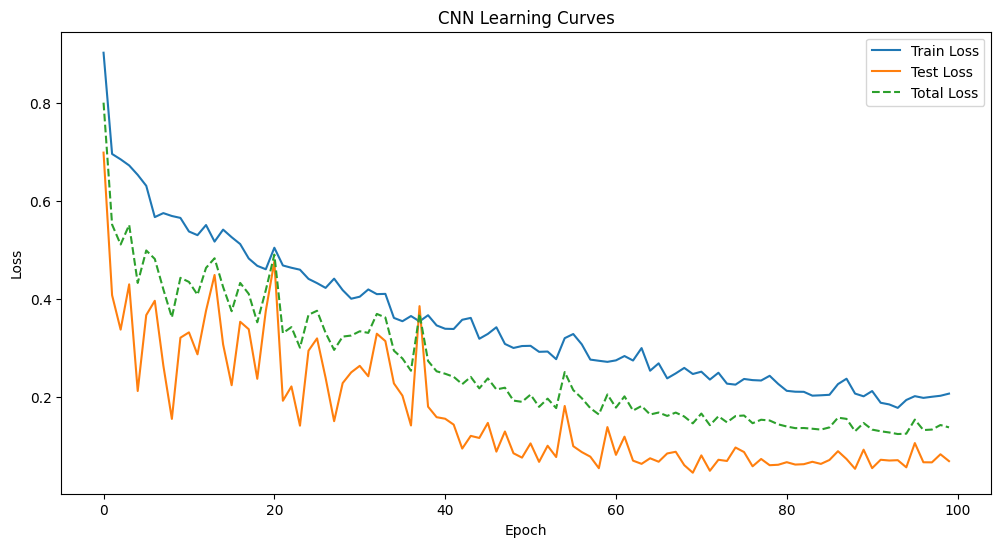

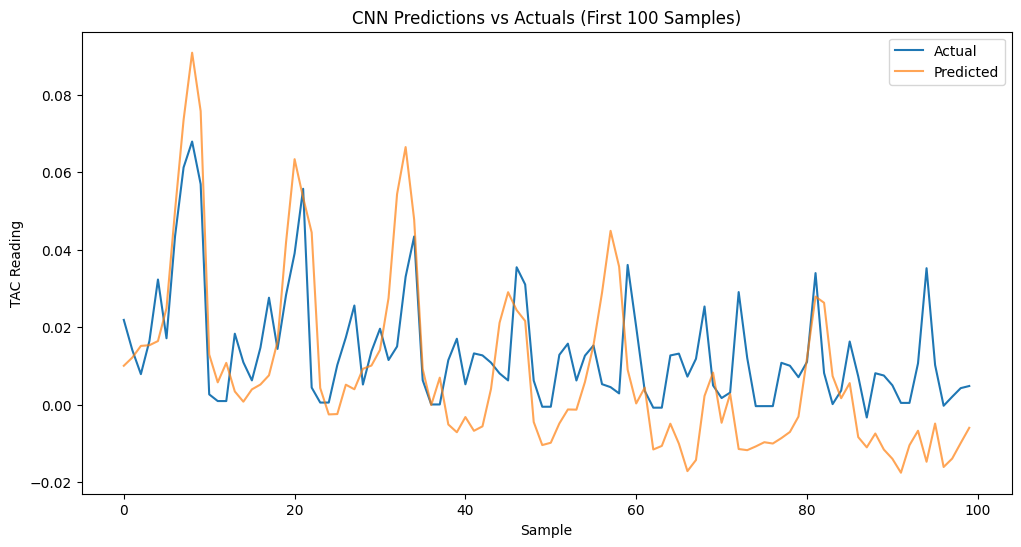


=== Final Model Comparison ===
          RMSE        R2
FNN   0.014149 -0.044582
RNN   0.015943 -0.326293
LSTM  0.017040 -0.515161
CNN   0.015748 -0.294143

=== Example of Loading a Saved Model ===
Successfully loaded LSTM model with input_size=6


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# from torch.utils.data import TensorDataset, DataLoader

# # Create directories if they don't exist
# os.makedirs("models", exist_ok=True)
# os.makedirs("learning_curves", exist_ok=True)
# os.makedirs("results", exist_ok=True)

# # ===================== DATA PREPARATION =====================
# def prepare_data(data_path):
#     # Load and prepare data
#     data = pd.read_csv(data_path)
#     data = data.dropna()

#     # Convert timestamp to datetime and sort
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.sort_values('timestamp')

#     # Feature engineering
#     def create_time_features(df):
#         df = df.copy()
#         df['hour'] = df['timestamp'].dt.hour
#         df['minute'] = df['timestamp'].dt.minute
#         df['day_of_week'] = df['timestamp'].dt.dayofweek
#         df['day_of_month'] = df['timestamp'].dt.day
#         df['time_sin'] = np.sin(2 * np.pi * df['hour']/24)
#         df['time_cos'] = np.cos(2 * np.pi * df['hour']/24)
#         return df

#     data = create_time_features(data)

#     # Normalize features and target
#     feature_scaler = StandardScaler()
#     target_scaler = StandardScaler()

#     features = ['hour', 'minute', 'day_of_week', 'day_of_month', 'time_sin', 'time_cos']
#     target = ['TAC_Reading']

#     X = feature_scaler.fit_transform(data[features].values)
#     y = target_scaler.fit_transform(data[target].values)

#     # Convert to sequences
#     def create_sequences(X, y, seq_length=24):
#         X_seq, y_seq = [], []
#         for i in range(len(X) - seq_length):
#             X_seq.append(X[i:i+seq_length])
#             y_seq.append(y[i+seq_length])
#         return np.array(X_seq), np.array(y_seq)

#     seq_length = 24
#     X_seq, y_seq = create_sequences(X, y, seq_length)

#     # Split data
#     split_idx = int(0.8 * len(X_seq))
#     X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
#     y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

#     # Convert to tensors
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
#     X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#     y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#     # Create DataLoaders
#     batch_size = 32
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)

#     return {
#         'train_loader': train_loader,
#         'test_loader': test_loader,
#         'feature_scaler': feature_scaler,
#         'target_scaler': target_scaler,
#         'input_size': len(features),
#         'seq_length': seq_length
#     }

# # ===================== MODEL DEFINITIONS =====================
# class FNN(nn.Module):
#     def __init__(self, input_size, seq_length):
#         super(FNN, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(input_size * seq_length, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)
        
#     def forward(self, x):
#         x = self.flatten(x)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size=64, num_layers=2):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.rnn(x, h0)
#         out = self.fc(out[:, -1, :])
#         return out

# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size=64, num_layers=2):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# class CNN(nn.Module):
#     def __init__(self, input_size, seq_length):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, stride=1)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
#         self.pool = nn.MaxPool1d(kernel_size=2)
        
#         conv1_size = seq_length - 3 + 1
#         pool1_size = conv1_size // 2
#         conv2_size = pool1_size - 3 + 1
#         pool2_size = conv2_size // 2
        
#         self.fc1 = nn.Linear(64 * pool2_size, 64)
#         self.fc2 = nn.Linear(64, 1)
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = torch.relu(self.conv1(x))
#         x = self.pool(x)
#         x = torch.relu(self.conv2(x))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # ===================== MODEL TRAINING =====================
# def train_model(model, train_loader, test_loader, model_name, epochs=100, lr=0.001):
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
#     train_losses = []
#     test_losses = []
#     total_losses = []
    
#     for epoch in range(epochs):
#         model.train()
#         epoch_train_loss = 0
#         for batch_X, batch_y in train_loader:
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()
            
#             epoch_train_loss += loss.item()
        
#         avg_train_loss = epoch_train_loss / len(train_loader)
#         train_losses.append(avg_train_loss)
        
#         model.eval()
#         epoch_test_loss = 0
#         with torch.no_grad():
#             for batch_X, batch_y in test_loader:
#                 batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#                 outputs = model(batch_X)
#                 epoch_test_loss += criterion(outputs, batch_y).item()
        
#         avg_test_loss = epoch_test_loss / len(test_loader)
#         test_losses.append(avg_test_loss)
        
#         total_loss = (avg_train_loss + avg_test_loss) / 2
#         total_losses.append(total_loss)
        
#         if (epoch+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], {model_name} - Train: {avg_train_loss:.4f}, Test: {avg_test_loss:.4f}, Total: {total_loss:.4f}')
    
#     # Save learning curves
#     learning_curves = pd.DataFrame({
#         'epoch': range(1, epochs+1),
#         'train_loss': train_losses,
#         'test_loss': test_losses,
#         'total_loss': total_losses
#     })
#     learning_curves.to_csv(f'learning_curves/{model_name}_learning_curves.csv', index=False)
    
#     # Save the model
#     torch.save(model.state_dict(), f'models/{model_name}.pt')
    
#     return model, train_losses, test_losses, total_losses

# # ===================== MODEL EVALUATION =====================
# def evaluate_model(model, data_loader, target_scaler):
#     model.eval()
#     predictions = []
#     actuals = []
#     with torch.no_grad():
#         for batch_X, batch_y in data_loader:
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#             outputs = model(batch_X)
#             predictions.extend(outputs.cpu().numpy())
#             actuals.extend(batch_y.cpu().numpy())
    
#     predictions = np.array(predictions).flatten()
#     actuals = np.array(actuals).flatten()
    
#     predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
#     actuals = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
#     rmse = np.sqrt(mean_squared_error(actuals, predictions))
#     r2 = r2_score(actuals, predictions)
    
#     return predictions, actuals, rmse, r2

# # ===================== MODEL LOADING =====================
# def load_model(model_name, input_size, seq_length):
#     model_map = {
#         'FNN': FNN(input_size, seq_length),
#         'RNN': RNN(input_size),
#         'LSTM': LSTM(input_size),
#         'CNN': CNN(input_size, seq_length)
#     }
    
#     if model_name not in model_map:
#         raise ValueError(f"Unknown model type: {model_name}. Available: {list(model_map.keys())}")
    
#     model = model_map[model_name].to(device)
#     model.load_state_dict(torch.load(f'models/{model_name}.pt'))
#     model.eval()
#     return model

# # ===================== MAIN EXECUTION =====================
# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Prepare data
#     data_prep = prepare_data("data/merged_data/tac_data_processed.csv")
#     train_loader = data_prep['train_loader']
#     test_loader = data_prep['test_loader']
#     feature_scaler = data_prep['feature_scaler']
#     target_scaler = data_prep['target_scaler']
#     input_size = data_prep['input_size']
#     seq_length = data_prep['seq_length']

#     # Initialize models
#     models = {
#         'FNN': FNN(input_size, seq_length).to(device),
#         'RNN': RNN(input_size).to(device),
#         'LSTM': LSTM(input_size).to(device),
#         'CNN': CNN(input_size, seq_length).to(device)
#     }

#     # Train and evaluate all models
#     results = {}
#     for model_name, model in models.items():
#         print(f"\n=== Training {model_name} model ===")
#         trained_model, train_loss, test_loss, total_loss = train_model(
#             model, train_loader, test_loader, model_name, epochs=100
#         )
        
#         # Evaluate
#         preds, actuals, rmse, r2 = evaluate_model(trained_model, test_loader, target_scaler)
#         results[model_name] = {
#             'RMSE': rmse,
#             'R2': r2,
#             'predictions': preds,
#             'actuals': actuals
#         }
        
#         # Save results
#         pd.DataFrame({
#             'actual': actuals,
#             'predicted': preds
#         }).to_csv(f'results/{model_name}_predictions.csv', index=False)
        
#         # Plot learning curves
#         plt.figure(figsize=(12, 6))
#         plt.plot(train_loss, label='Train Loss')
#         plt.plot(test_loss, label='Test Loss')
#         plt.plot(total_loss, label='Total Loss', linestyle='--')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title(f'{model_name} Learning Curves')
#         plt.legend()
#         plt.savefig(f'learning_curves/{model_name}_learning_curves.png')
#         plt.show()
        
#         # Plot predictions vs actuals
#         plt.figure(figsize=(12, 6))
#         plt.plot(actuals[:100], label='Actual')
#         plt.plot(preds[:100], label='Predicted', alpha=0.7)
#         plt.xlabel('Sample')
#         plt.ylabel('TAC Reading')
#         plt.title(f'{model_name} Predictions vs Actuals (First 100 Samples)')
#         plt.legend()
#         plt.savefig(f'results/{model_name}_predictions_vs_actuals.png')
#         plt.show()

#     # Save final metrics comparison
#     metrics_df = pd.DataFrame.from_dict(results, orient='index')[['RMSE', 'R2']]
#     metrics_df.to_csv('results/model_comparison.csv')
#     print("\n=== Final Model Comparison ===")
#     print(metrics_df)

#     # Example of loading a saved model
#     print("\n=== Example of Loading a Saved Model ===")
#     loaded_model = load_model('LSTM', input_size, seq_length)
#     print(f"Successfully loaded LSTM model with input_size={input_size}")